In [1]:
# imports
import os
import numpy as np
import time
from tinygrad import Tensor
from tinygrad import Device
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

Device.DEFAULT = "GPU" # set to tinygrad backend to GPU since METAL doesn't work on older intel macs
print(Device.DEFAULT)

GPU


In [2]:
# import and clean pokemon name data

import csv

moves = []

with open('Pokemon_moves.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) # skips header row
    for row in reader:
        if len(row) > 1:
            moves.append(row[0])

print(f'first five moves in dataset:')
print(moves[:5])
print(f'total number of moves: {len(moves)}')

first five moves in dataset:
['10,000,000 Volt Thunderbolt', 'Absorb', 'Accelerock', 'Acid', 'Acid Armor']
total number of moves: 724


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(moves))))
# stoi = string to int, itos = int to string
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # set . as end char, since all other end chars are already used
itos = {i:s for s,i in stoi.items()}
print(itos)

# finding # of unique chars so we can set our Tensor dim. later
all_chars = set(''.join(stoi))
num_unique_chars = len(all_chars)

print('num_unique_chars =', num_unique_chars)
print('all_chars = ', all_chars)

{1: ' ', 2: "'", 3: ',', 4: '-', 5: '0', 6: '1', 7: '2', 8: '7', 9: 'A', 10: 'B', 11: 'C', 12: 'D', 13: 'E', 14: 'F', 15: 'G', 16: 'H', 17: 'I', 18: 'J', 19: 'K', 20: 'L', 21: 'M', 22: 'N', 23: 'O', 24: 'P', 25: 'Q', 26: 'R', 27: 'S', 28: 'T', 29: 'U', 30: 'V', 31: 'W', 32: 'X', 33: 'Y', 34: 'Z', 35: 'a', 36: 'b', 37: 'c', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'i', 44: 'k', 45: 'l', 46: 'm', 47: 'n', 48: 'o', 49: 'p', 50: 'q', 51: 'r', 52: 's', 53: 't', 54: 'u', 55: 'v', 56: 'w', 57: 'x', 58: 'y', 59: 'z', 0: '.'}
num_unique_chars = 60
all_chars =  {'H', '0', 'f', 'p', 'B', 'E', 'g', 'x', 'P', 's', 'K', 'Z', 'b', 'L', 'Y', ' ', 'C', 'F', 'U', '7', 'l', 'o', 'k', 'y', 'z', '2', 'O', 'r', 'a', 't', ',', 'c', 'v', 'd', 'S', 'm', 'u', 'h', '1', 'J', 'V', 'X', '-', '.', 'w', 'n', 'M', 'D', 'I', 'N', 'T', 'W', 'e', 'q', 'R', "'", 'i', 'Q', 'A', 'G'}


In [4]:
# build the dataset ( in terms of train, val, and test sets )

block_size = 8 # context length: how many chars do we take to predict the next on?

def build_dataset(moves):
    
    X, Y = [], [] # X = inputs, Y = labels
    
    for n in moves:
    
        #print(n)
        context = [0] * block_size # start with padded context
    
        # iter over all chars
        for ch in n + '.':
            ix = stoi[ch] # get char in sequence
            X.append(context) # stores current running context
            Y.append(ix) # stores current char
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append (rolling window of context)
    
    X = Tensor(X)
    Y = Tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.shuffle(moves)
n1 = int(0.8*len(moves))
n2 = int(0.9*len(moves))

Xtr, Ytr = build_dataset(moves[:n1])
Xdev, Ydev = build_dataset(moves[n1:n2])
Xte, Yte = build_dataset(moves[n2:])

(6396, 8) (6396,)
(799, 8) (799,)
(841, 8) (841,)


In [132]:
n_embd = 8 # the dimensionality of the character embedding vectors
n_hidden = 32 # the number of neurons in the hidden layer of the MLP

class PokeMoveNet:
    def __init__(self, num_unique_chars, n_embd, n_hidden, block_size):
        self.C = Tensor.randn(num_unique_chars, n_embd)
        self.W1 = Tensor.randn(n_embd * block_size, n_hidden) * ( (5.0/3.0) / (n_embd * block_size)**0.5 )#* 0.14
        self.b1 = Tensor.randn(n_hidden) * 0.01
        self.W2 = Tensor.randn(n_hidden, num_unique_chars) * 0.01
        self.b2 = Tensor.randn(num_unique_chars) * 0 # to help set logits to 0

        
        # batch norm parameters
        self.bngain = Tensor.ones(1, n_hidden)
        self.bnbias = Tensor.zeros(1, n_hidden)
        self.bnmean_running = Tensor.zeros(1, n_hidden)
        self.bnstd_running = Tensor.ones(1, n_hidden)

        # register all parameters
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2, self.bngain, self.bnbias]
        for p in self.parameters:
            p.requires_grad = True

    def __call__(self, X): # X: (B, block_size
        
        # forward pass
        emb = self.C[X] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

        # linear layer
        hpreact = embcat @ self.W1 # + self.b1 # hidden layer pre-activation

        # batch norm layer
        bnmeani = hpreact.mean(0, keepdim=True)
        bnstdi = hpreact.std(0, keepdim=True)
        hpreact = self.bngain * (hpreact - bnmeani) / bnstdi + 0.001 + self.bnbias # batch norm

        self.bnmean_running.replace(0.999 * self.bnmean_running + 0.001 * bnmeani).realize()
        self.bnstd_running.replace(0.999 * self.bnstd_running + 0.001 * bnstdi).realize()

        # non-linearity
        h = hpreact.tanh() # hidden layyer

        # output layer
        logits = h @ self.W2 + self.b2 # output layer
        return logits

In [133]:
net = PokeMoveNet(num_unique_chars=num_unique_chars, n_embd=n_embd, n_hidden=n_hidden, block_size=block_size)
print('net loaded...')
print('num of parameters: ', sum(p.numel() for p in net.parameters)) # numb of params in total

net loaded...
num of parameters:  4604


In [137]:
# training
max_steps = 2000
batch_size = 128
lossi = []

# training
import time
total_start = time.time()
batch_start = time.time()

with Tensor.train():
    for i in range(max_steps):

        # minibatch construct
        ix = Tensor.randint(batch_size, low=0, high=Xtr.shape[0], requires_grad=False)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

        # forward pass
        out = net(Xb)
    
        # compute loss
        loss = out.cross_entropy(Yb)
    
        # zero gradients
        for p in net.parameters:
            p.grad = p.zeros_like()
        
        # backwards pass
        loss.backward()
        
        # update parameters
        lr = 0.1 if i < 1000 else 0.01 # step learning rate decay
        for p in net.parameters:
            p.replace(p.add(-lr * p.grad))

        # calculate accuracy
        pred = out.argmax(axis=-1)
        acc = (pred == Yb).mean()
    
        # track stats
        if i % 100 == 0:
            batch_end = time.time()
            print(f"Step {i+1}/{max_steps} | Loss: {loss.numpy():.4f} | Accuracy {acc.numpy()} | Time taken {batch_end - batch_start:.2f}s")
            batch_start = time.time()
        lossi.append(loss.log().numpy() / Tensor(10).log().numpy())
        
total_end = time.time()
print('Time taken: ', total_end - total_start)


Step 1/2000 | Loss: 3.0200 | Accuracy 0.2109375 | Time taken 0.31s
Step 101/2000 | Loss: 3.1949 | Accuracy 0.171875 | Time taken 25.52s
Step 201/2000 | Loss: 3.1248 | Accuracy 0.171875 | Time taken 24.81s
Step 301/2000 | Loss: 3.1509 | Accuracy 0.1796875 | Time taken 26.88s
Step 401/2000 | Loss: 3.2188 | Accuracy 0.1484375 | Time taken 25.10s
Step 501/2000 | Loss: 2.9261 | Accuracy 0.21875 | Time taken 26.98s
Step 601/2000 | Loss: 2.9368 | Accuracy 0.234375 | Time taken 28.27s
Step 701/2000 | Loss: 3.2799 | Accuracy 0.125 | Time taken 27.23s
Step 801/2000 | Loss: 3.0964 | Accuracy 0.1640625 | Time taken 26.75s
Step 901/2000 | Loss: 3.0307 | Accuracy 0.1796875 | Time taken 27.57s
Step 1001/2000 | Loss: 3.0876 | Accuracy 0.15625 | Time taken 30.07s
Step 1101/2000 | Loss: 2.8617 | Accuracy 0.15625 | Time taken 29.75s
Step 1201/2000 | Loss: 2.9896 | Accuracy 0.171875 | Time taken 27.92s
Step 1301/2000 | Loss: 2.9390 | Accuracy 0.1953125 | Time taken 34.00s
Step 1401/2000 | Loss: 3.0286 | A

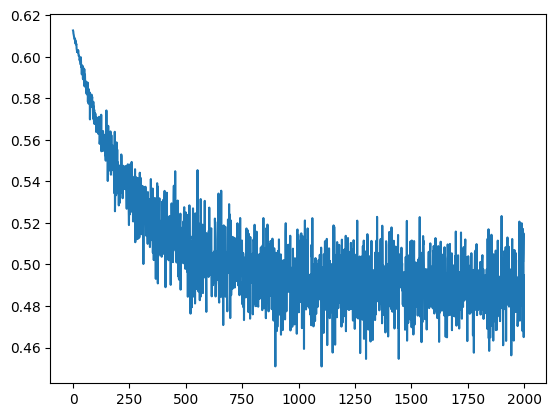

In [135]:
plt.plot(lossi)

In [76]:
# calibrate the batch norm at the end of training

# pass the training set through
emb = net.C[Xtr]
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ net.W1
# measure the mean/stf over the entire training set
bnmean = hpreact.mean(0, keepdim=True)
bnstd = hpreact.std(0, keepdim=True)

In [153]:
# setting up JIT to speed up testing
from tinygrad import TinyJit

@TinyJit
def jit(x):
    return net(x).realize()

In [136]:
# testing
def split_loss(split):
    
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    #out = jit(x)
    # pass the training set through
    emb = net.C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ net.W1 # + net.b1
    hpreact = net.bngain * (hpreact - net.bnmean_running) / net.bnstd_running + net.bnbias
    h = hpreact.tanh()
    logits = h @ net.W2 + net.b2
    loss = logits.cross_entropy(y)
    print(split, loss.numpy())

split_loss('train')
split_loss('val')

train 3.0822206
val 3.1499884


In [ ]:
# og -> (2.9, 3.1)
# fix softmax confidentally wrong -> (3.1, 3.2)
# fix tanh layer too saturated at init -> (2.23, 2.53)
# setting kaiming init -> (2.8, 2.9)
# batch norm -> (2.68, 2.84)

In [131]:
# sample from model

@TinyJit
def sample_jit(x):
    return net(x).realize()

for _ in range(10):

    out = []
    context = [0] * block_size # initialize with all ........ starting chars

    while True:
        
        # forward pass with not-jit (broken after batchnorm in init)
        #logits = sample_jit(Tensor([context])
        emb = net.C[Tensor([context])]
        embcat = emb.view(1, -1) # concatenate the vectors
        hpreact = embcat @ net.W1 + net.b1 # hidden layer pre-activation
        h = hpreact.tanh()
        logits = h @ net.W2 + net.b2

        # calculate output probabilities
        probs = logits.softmax(axis=1)
        probs.realize()

        # sample from distribution
        ix = probs.multinomial(num_samples=1).item()

        # shift the context window and track the samples (rolling context window)
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    # decode and print the generated word
    print(''.join(itos[i] for i in out))

#emb = C[Tensor(context)] # (1, block_size, d)
#boof
#skalk stick

SHwoemSPWWRqe.
MBDOIkSumoee lJacpaCQJ'hvdBTad tp-aod.
oLoef lDcl.
DRoWkFEe BPiBmllel.
GSk2uGCl ,.
oEelrefGntgd.
lzthtaSl.
xOnpuCnon eSge0o.
Poec SPF ErTnceL.
uigcS uoal lctterg1eU-.


In [1]:
### summary ------

In [31]:
# lets train a deeper network, in a more abstract modular way

class Linear:
  def __init__(self, in_features, out_features, bias=True):
    self.weight = Tensor.randn(in_features, out_features) / in_features**0.5
    self.bias = Tensor.zeros(out_features) if bias else None

  def __call__(self, x):
      self.out = x.linear(self.weight, self.bias)
      return self.out
      
  def parameters(self):
      return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters (trained with backprop)
        self.gamma = Tensor.ones(dim)
        self.beta = Tensor.zeros(dim)
        
        # buffers (trained with a running 'momentum update')
        self.running_mean = Tensor.zeros(dim, requires_grad=False)
        self.running_var = Tensor.ones(dim, requires_grad=False)

    def __call__(self, x):
        #calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / (xvar + self.eps).sqrt() # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            self.running_mean.replace(((1 - self.momentum) * self.running_mean + self.momentum * xmean).reshape(self.running_mean.shape))
            self.running_var.replace(((1 - self.momentum) * self.running_var + self.momentum * xvar).reshape(self.running_var.shape))
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    def parameters(self):
        return []

n_embd = 8 # the dimensionality of the character emdedding vectors
n_hidden = 16 # the number of neurons in the hidden layer of the MLP

C = Tensor.randn(num_unique_chars, n_embd)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, num_unique_chars), BatchNorm1d(num_unique_chars)
]


# last layer: make less confident
#layers[-1].weight *= 0.1
layers[-1].gamma *= 0.1 # since batchnorm is last layer now

# all other layers: apply gain
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

3908


In [32]:
# TRAINING // same optimization as last time
max_steps = 100
batch_size = 32
lossi = []
ud = []

# caching static values
log10 = Tensor(10).log()

import gc

total_start = time.time()
batch_start = time.time()

for i in range(100):

  Tensor.training = True
      
  # minibatch construct
  ix = Tensor.randint(batch_size, low=0, high=Xtr.shape[0], requires_grad=False)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = x.cross_entropy(Yb) # loss function
  
  # backward pass
  #for layer in layers:
  #  layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 1 if i < 500 else 0.1 # step learning rate decay
  for p in parameters:
    p.assign(p.add(-lr * p.grad))

  # track stats
  if i % 100 == 0: # realize & print every once in a while
    Tensor.training = False
    
    batch_end = time.time()
    print(f"Step {i+1}/{max_steps} | Loss {loss.numpy():.4f} | Time taken {batch_end - batch_start:.2f}s")
    batch_start = time.time()

      
  #lossi.append((loss.log() / log10).numpy())

  Tensor.training = False
  ud.append([((lr*p.grad).std() / p.std() / log10).numpy() for p in parameters])

total_end = time.time()
print('Time taken: ', total_end - total_start)


Step 1/100 | Loss 4.1018 | Time taken 0.22s



KeyboardInterrupt



layer 2 (      Tanh): mean -0.01, std 0.61, saturated: 3.32%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.73%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.73%
layer 11 (      Tanh): mean +0.02, std 0.63, saturated: 2.93%
layer 14 (      Tanh): mean -0.02, std 0.64, saturated: 2.34%


Text(0.5, 1.0, 'activation distribution')

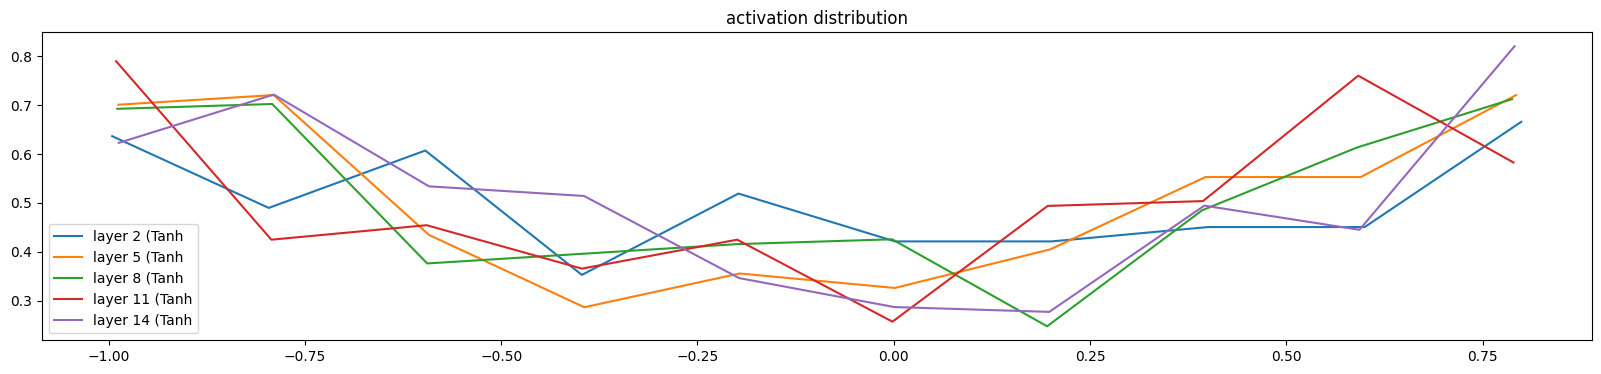

In [22]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (
        i,
        layer.__class__.__name__,
        t.mean().numpy(),
        t.std().numpy(),
        ((t.abs() > 0.97).mean()*100).numpy()
    ))
    hy, hx = np.histogram(t.numpy(), density=True)
    plt.plot(hx[:-1], hy)
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

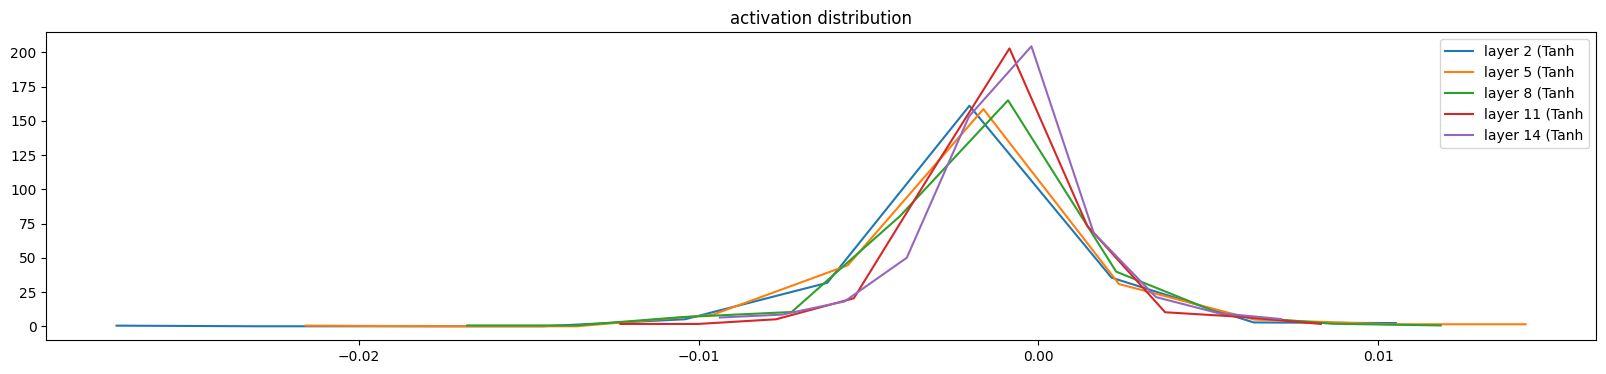

In [23]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (
        i,
        layer.__class__.__name__,
        t.mean().numpy(),
        t.std().numpy(),
        ((t.abs() > 0.97).mean()*100).numpy()
    ))
    hy, hx = np.histogram(t.numpy(), density=True)
    plt.plot(hx[:-1], hy)
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

weight    (60, 8) | mean -0.000000 | std 2.741551e-03 | grad:data ratio -1.415444e-09
weight   (64, 16) | mean +0.000135 | std 9.319342e-03 | grad:data ratio 1.448724e-02
weight   (16, 16) | mean +0.000304 | std 7.883580e-03 | grad:data ratio 3.852930e-02
weight   (16, 16) | mean +0.000010 | std 7.819067e-03 | grad:data ratio 1.316871e-03
weight   (16, 16) | mean -0.000142 | std 6.853620e-03 | grad:data ratio -2.076098e-02
weight   (16, 16) | mean +0.000575 | std 6.314008e-03 | grad:data ratio 9.102444e-02
weight   (16, 60) | mean -0.000212 | std 3.250667e-03 | grad:data ratio -6.508353e-02


Text(0.5, 1.0, 'weights gradient distribution')

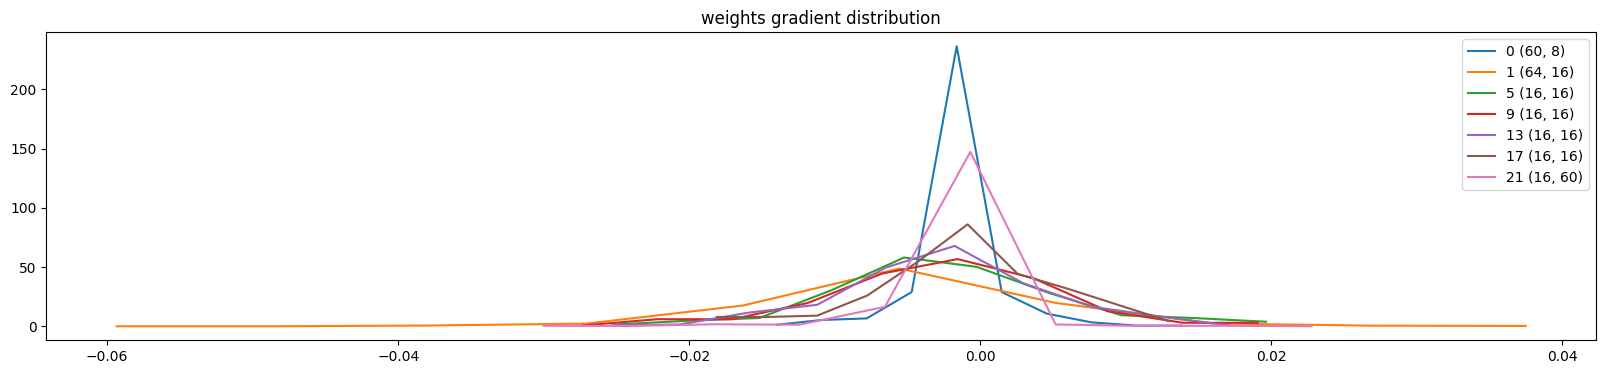

In [24]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, p in enumerate(parameters): # note: exclude the output layer
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' %  (
            tuple(p.shape),
            t.mean().numpy(),
            t.std().numpy(),
            (t.mean() / t.std()).numpy()
        ))
        hy, hx = np.histogram(t.numpy(), density=True)
        plt.plot(hx[:-1], hy)
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution')

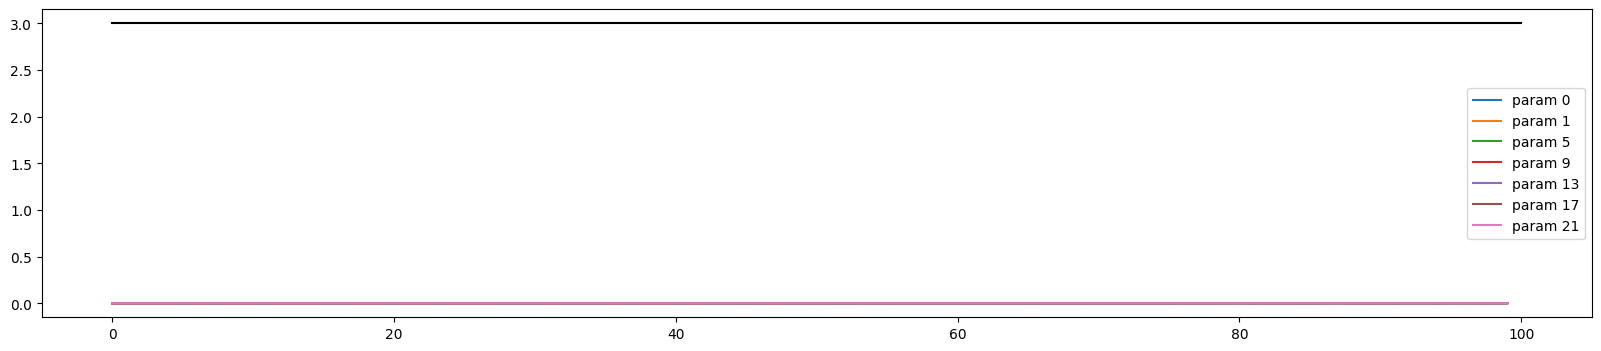

In [28]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [3, 3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);